# Algal Bloom Detection
## Example how to reproject vector data, clean scenes from the clouds and detect harmful algal blooms based on the Landsat 8 data

1. Import Python libraries and functions.
2. Prepare time series Data Frame with Landsat 8 scenes (class RasterTimeSeries).
3. Prepare class which reads, stores, shows and reprojects vector shapefiles.
4. Example 1: differences between projections.
5. Example 2: errors with clipping data with different projections.
6. Example 3: clip raster.
7. Clip multiple rasters and update dataframe.
8. Calculate Enhanced Vegetation Index EVI.
9. Why will it be very hard to obtain a valid results? - an example
10. Calculate EVI with corrected data.
11. Clouds and remote sensing.
12. Algal bloom detection and analysis.

### 1. Import Python libraries and functions.

In [1]:
%matplotlib inline

# Base
import os
import numpy as np
import pandas as pd

# Spatial analysis
import rasterio as rio
import fiona as fio
from fiona.crs import from_epsg
from pyproj import Proj, transform

# Visualization
import matplotlib.pyplot as plt

# Additional scripts
from scripts.clip_area import clip_area
from scripts.read_landsat_images import read_landsat_images
from scripts.show_band import show_band

### 2. Prepare time series Data Frame with Landsat 8 scenes (class RasterTimeSeries).

In [2]:
class RasterTimeSeries:
    """Class prepares dataframe object with addresses to the folders with landsat bands. Dataframe index is a time when each scene was retrieved.
    It is initialized with the folder which contains all landsat bands.
    
    Class methods:
    prepare_directories(main_folder=None) - method prepares a list of folders with satellite images. Method performs search in the parent directory
    given by the user or if it is None then it is taken from the class itself."""
    
    def __init__(self, main_folder):
        self.main_folder = main_folder
        self.landsat_folders = None
        self.landsat_dataframe = None
    
    def prepare_directories(self, main_folder=None):
        """Function prepares list with Landsat images directories in the given folder.
        input 1: main_folder (string)
        If None then self.main_folder is used as the parent directory of the folders with satellite images.
        output: prepared_list - list with all folders with satellite images."""
        
        if main_folder:
            folder_name = os.listdir(main_folder)
        else:
            folder_name = self.main_folder
        raw_list = os.listdir(folder_name)
        prepared_list = []
        for folder in raw_list:
            if ((folder.startswith('LC')) and not (folder.endswith('.tar.gz'))):
                prepared_list.append(folder_name + '/' + folder + '/')
        self.landsat_folders = prepared_list
        return prepared_list
    
    @staticmethod
    def read_timestamp(folder):
        """Function reads date of acquisition of each Landsat 8 scene based on the folder with MTL file.
        input 1: folder - string with Landsat folder (MTL file must be placed in it).
        output: string with the scene acquisition time"""
    
        files = os.listdir(folder)
        for file in files:
            if file.startswith('LC') and file.endswith('MTL.txt'):
                address = folder + '/' + file
                with open(address, 'r') as f:
                    for line in f:
                        line = ''.join(line.split())
                        if line.startswith('DATE_ACQUIRED='):
                            line = line.replace('DATE_ACQUIRED=', '')
                            return line
    
    def prepare_dataframe(self):
        """Function prepares dataframe with index column as a date of acquisition and the main column DIR which points
        to the directories with Landsat 8 images. Function takes one argument: the list of folders with Landsat 8 datasets.
        output: pandas dataframe with indexes set to the dates of acquisition and column indices folders with Landsat images."""
        
        # DataFrame preparation
        time_series = pd.DataFrame(self.landsat_folders, columns=['DIR'])
        time_series.index = time_series['DIR'].apply(lambda x: str(pd.to_datetime(self.read_timestamp(x)).date()))
        time_series.index.name = 'DATE'
        time_series = time_series.sort_index()
        self.landsat_dataframe = time_series
        return time_series
    
    def __str__(self):
        if self.landsat_folders is None:
            return('Parent folder of all scenes: {}.\
            \nList of subfolders is not created.\
            \nDataframe with dates is not created.'.format(
            self.main_folder))
        elif self.landsat_dataframe is None:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe with dates is not created.'.format(
            self.main_folder, len(self.landsat_folders)))
        else:
            return('Parent folder of all scenes: {}\
            \nList of subfolders has {} directories.\
            \nDataframe is created. List of all dates: {}.'.format(
            self.main_folder,
            len(self.landsat_folders),
            self.landsat_dataframe.index.values))

In [3]:
folder = 'data/rasters'
algal_blooms = RasterTimeSeries(folder)
print(algal_blooms)

Parent folder of all scenes: data/rasters.            
List of subfolders is not created.            
Dataframe with dates is not created.


In [4]:
algal_blooms.prepare_directories()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 14 directories.            
Dataframe with dates is not created.


In [5]:
algal_blooms.prepare_dataframe()
print(algal_blooms)

Parent folder of all scenes: data/rasters            
List of subfolders has 14 directories.            
Dataframe is created. List of all dates: ['2013-04-15' '2013-05-01' '2013-05-17' '2013-06-18' '2013-08-05'
 '2013-09-06' '2014-07-07' '2015-04-21' '2015-08-11' '2017-04-10'
 '2017-05-12' '2017-05-28' '2018-04-13' '2018-05-31'].


### 3. Prepare class which reads, stores, shows and reprojects vector shapefiles.

In [6]:
# Helper function to prepare the data

def get_epsg_from_raster(raster_address):
    """Function reads raster data and gets its coordinate reference system. 
    Then it is converted to the European Petroleum Survey Group (EPSG) reference number."""
    with rio.open(raster_address) as f:
        band_crs = f.crs
        destination_epsg = band_crs['init'][5:]
        destination_epsg = int(destination_epsg)
    return destination_epsg


# The main class for vector file handling

class VectorData:
    """Class reads, stores, shows and reprojects vector shapefiles.
    It is initialized with filename.
    
    Class methods:
    get_vector_data(parameters='all', write_params=True) - method reads vector data and parse its parameters such as geometry,
    properties, crs and schema into dictionaries. Method may store parameters inside the object if write_params is set
    to True. Method returns desired parameters.
    reproject_geometry(destination_epsg, update=False) - method changes projection of each point inside the Polygon into
    projection given as an epsg number. It may update object geometry if the update parameter is set to True. Method returns
    reprojected geometry dictionary.
    show_vector_data(geometry=None) - method shows polygon. If geometry is not given then method uses class geometry."""
    
    def __init__(self, filename):
        self.v_file = filename
        self.geometry = {}
        self.properties = None
        self.vec_crs = None
        self.vec_schema = None
        
    def get_vector_data(self, parameters='all', write_params=True):
        """
        Function reads vector and its parameters and return them and / or store them inside the objects instance.
        input 1: parameters (string)
        parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'
        'all': returns tuple with geometry, properties, crs and schema;
        'none': does not return anything;
        'geometry', 'properties', 'crs' or 'schema': returns chosen parameter.
        input 2: write_params (bool)
        write_params: True, False
        True: store all parameters in the object
        False: do not store anything in the object
        output: chosen parameters as a dict"""
        
        with fio.open(vector_file, 'r') as masking_region:
            geometry = [feature["geometry"] for feature in masking_region]
            properties = [feature['properties'] for feature in masking_region]
            vec_crs = masking_region.crs
            vec_schema = masking_region.schema
        
        if write_params:
            print('--- Object geometry, properties, crs and schema updated ---')
            self.geometry = geometry
            self.properties = properties
            self.vec_crs = vec_crs
            self.vec_schema = vec_schema
        else:
            print('--- Object parameters not updated ---')
            
        output_dict = {'all': ({'geometry': geometry, 'properties': properties, 'crs': vec_crs, 'scheme': vec_schema}),
                      'none': 0,
                      'geometry': geometry,
                      'properties': properties,
                      'crs': vec_crs,
                      'schema': vec_schema}
        try:
            return output_dict[parameters]
        except KeyError:
            raise KeyError("Parameter not available. Available parameters: 'all', 'none', 'geometry', 'properties', 'crs', 'schema'")
      
    def reproject_geometry(self, destination_epsg, update=False):
        """
        Function reprojects vector geometry and may update objects geometry.
        input 1: destination_epsg (string or int)
        input 2: update (bool)
        True: update object's geometry
        False: do not update object's geometry
        output: reprojected geometry as a dict"""
        
        try:
            destination_crs = from_epsg(destination_epsg)
            proj_crs_in = Proj(self.vec_crs)
            coordinates_list = self.geometry[0]['coordinates'][0]
        except RuntimeError:
            raise ValueError('Given EPSG is wrong or it is not stored in fiona to run from_epsg method')
        except KeyError:
            raise ValueError('You must update your object parameters by get_vector_data method with write_params set to True.')
        proj_crs_out = Proj(init = destination_crs['init'])
        coordinates_array = np.asarray(coordinates_list)
        projected_g = []
        
        for g in coordinates_array:
            transformed = transform(proj_crs_in, proj_crs_out, g[0], g[1])
            points = (transformed[0], transformed[1],)
            projected_g.append(points)
        geometry_dict = {'coordinates': [projected_g], 'type': 'Polygon'}
        
        if update:
            self.geometry = [geometry_dict]
            self.vec_crs = destination_crs
            
        return [geometry_dict]
    
    def show_vector_data(self, geometry=None):
        """
        Function shows vector geometry.
        input 1: geometry (dict, geometry retrieved as a parameter from the vector data type).
        If geometry is not given then method takes it from the objects instance."""
        
        if geometry:
            g = geometry
        else:
            g = self.geometry
            
        try:
            coordinates_list = g[0]['coordinates'][0]
        except KeyError:
            raise ValueError(
                'Geometry is not defined. Please, update geometry with get_vector_data method or provide valid geometry object to the method.')
            
        coordinates_array = np.asarray(coordinates_list)
        plt.figure()
        plt.plot(coordinates_array[:, 0], coordinates_array[:, 1])
        plt.show()

### 4. Example 1: differences between projections.

--- Object geometry, properties, crs and schema updated ---


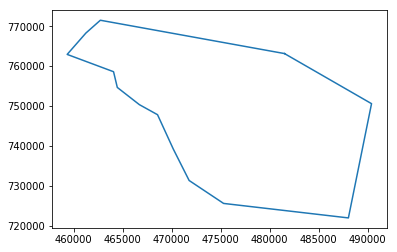

{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 19, 'k': 0.9993, 'x_0': 500000, 'y_0': -5300000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


In [7]:
vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vd = vector_data.get_vector_data('geometry', True)
vector_data.show_vector_data(vd)
print(vector_data.vec_crs)

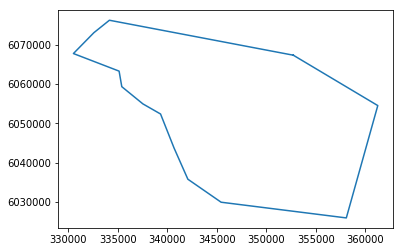

{'init': 'epsg:32634', 'no_defs': True}


In [8]:
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])
vn = vector_data.reproject_geometry(epsg, True)
vector_data.show_vector_data()
print(vector_data.vec_crs)

### 5. Example 2: errors with clipping data with different projections.

In [9]:
# Read and prepare vector data

vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)
print(vector_data.vec_crs)

--- Object geometry, properties, crs and schema updated ---
{'proj': 'tmerc', 'lat_0': 0, 'lon_0': 19, 'k': 0.9993, 'x_0': 500000, 'y_0': -5300000, 'ellps': 'GRS80', 'units': 'm', 'no_defs': True}


In [10]:
# Read raster file and check its crs

with rio.open(landsat_images[1]) as f:
    band_crs = f.crs

print(band_crs)

CRS({'init': 'epsg:32634'})


In [11]:
# Try to clip areas with different projections

clip_area(vector_data.geometry, landsat_images[1], 'data/failed_test.tif')

ValueError: Input shapes do not overlap raster.

### 6. Example 3: clip raster (valid one).

--- Object geometry, properties, crs and schema updated ---


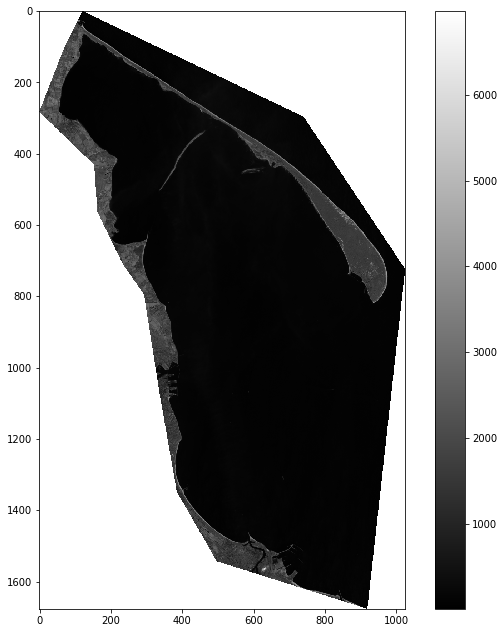

In [13]:
# Read and prepare vector data
vector_file = 'data/vector/zatoka_gdanska.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

# Clip raster and show it!
clip_area(vn, landsat_images[5], 'data/correct_test.tif')

# Show raster
with rio.open('data/correct_test.tif') as correct_clip:
    area_of_interst = correct_clip.read(1)
show_band(area_of_interst)

### 7. Clip multiple rasters and update dataframe.

In [19]:
def clip_all(dataset, clipping_vector, bands=(2, 3, 4), folder_name='clipped/'):
    """Function performs clipping of all Landsat 8 bands given in the DIR column of the df parameter.
    input 1: dataset - dataframe with DIR column where each record points to the directory with a Landsat bands
    input 2: clipping_vector - vector geometry which is used as a area of interest
    input 3: bands=(2, 3, 4) - tuple of bands which should be clipped. Bands 2, 3, 4 are used for the BGR image creation.
    input 4: folder_name='clipped/' - directory where all clipped bands should be stored.
    
    output: [correct, damaged] - list of dicts with keys (dates) and values - correct images
    and damaged images. Damaged images were not process and they not exist in the destination folder."""
    
    data_range = len(dataset)
    damaged = {}
    correct = {}
    for i in range(0, data_range):
        date_str = dataset.index[i]
        images = read_landsat_images(dataset['DIR'][i])
        for band_number in bands:
            band_to_clip = images[band_number]
            filename = folder_name + 'LC_band' + str(band_number) + '_' + date_str + '.tif'
            try:
                clip_area(vn, band_to_clip, filename)
            except (rio.errors.WindowError, ValueError):
                print('\nPolygon does not cover raster area. Error occurs when projections are different or raster extent is translated and it does not overlap polygon extent.\n')
                try: 
                    damaged[date_str].append(filename)
                except KeyError:
                    damaged[date_str] = [filename]
                pass
            
            # Check file
            try: 
                damaged[date_str]
                print('File: {} not saved. Raster has not been clipped.'.format(
                filename))
            except KeyError:
                try:
                    with rio.open(filename) as tf:
                         pass
                except rio.RasterioIOError:
                    raise IOError('File was: {} not saved successfully'.format(
                    filename))
                else:
                    print('File: {} saved successfully'.format(
                    filename))
                    try: 
                        correct[date_str].append(filename)
                    except KeyError:
                        correct[date_str] = [filename]
    return [correct, damaged]

In [20]:
my_bands = (2, 4, 5)  # bands for EVI calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, my_folder_name)

File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-06-18.tif saved successfully
File: data/clipped/LC_band4_2013-06-18.tif saved successfully
File: data/clipped/LC_band5_2013-06-18.tif saved successfully
File: data/clipped/LC_band2_2013-08-05.tif saved successfully
File: data/clipped/LC_band4_2013-08-05.tif saved successfully
File: data/clipped/LC_band5_2013-08-05.tif saved successfully
File: data/clipped/LC_band2_2013-09-06.tif saved successfully
File: da

In [34]:
def rasters_to_dataframe(raster_list, dataframe):
    """Function reads list of dictionaries with correct and damaged files. Keys in the dictionary are related to the dates
    of an image acquisition. The first list presents correct data. Second list represents damaged values.
    input 1: raster_list - list of dictionaries with correct and damaged files.
    input 2: dataframe - dataframe with dates which should be removed (if band is in the damaged list) or 
    updated with new columns with addresses to the correct raster files.
    
    output: clean_dataset - pandas dataframe with additional columns with addresses of the raster files. These files
    are intended to process them later."""
    
    damaged_list = list(raster_list[1].keys())
    clean_dataset = dataframe.drop(labels=damaged_list)
    correct_df = pd.DataFrame.from_dict(raster_list[0], orient='index')
    clean_dataset = clean_dataset.join(correct_df)
    return clean_dataset

In [37]:
clean_df = rasters_to_dataframe(prepared_files, df)
clean_df.head()

,DIR,0,1,2
DATE,,,,
2013-04-15,data/rasters/LC081900222013041501T1-SC20180614...,data/clipped/LC_band2_2013-04-15.tif,data/clipped/LC_band4_2013-04-15.tif,data/clipped/LC_band5_2013-04-15.tif
2013-05-01,data/rasters/LC081900222013050101T1-SC20180614...,data/clipped/LC_band2_2013-05-01.tif,data/clipped/LC_band4_2013-05-01.tif,data/clipped/LC_band5_2013-05-01.tif
2013-05-17,data/rasters/LC081900222013051701T1-SC20180614...,data/clipped/LC_band2_2013-05-17.tif,data/clipped/LC_band4_2013-05-17.tif,data/clipped/LC_band5_2013-05-17.tif
2013-06-18,data/rasters/LC081900222013061801T1-SC20180614...,data/clipped/LC_band2_2013-06-18.tif,data/clipped/LC_band4_2013-06-18.tif,data/clipped/LC_band5_2013-06-18.tif
2013-08-05,data/rasters/LC081900222013080501T1-SC20180614...,data/clipped/LC_band2_2013-08-05.tif,data/clipped/LC_band4_2013-08-05.tif,data/clipped/LC_band5_2013-08-05.tif


### 8. Calculate Enhanced Vegetation Index EVI.

In [38]:
# Calculate EVI

def calculate_evi(bands):
    """Function calculates evi indicator from given data and returns it as an evi map"""
    # sort bands based on their names
    bands.sort() # band 2, band 4, band 5
            
    with rio.open(bands[2]) as a:
        nir_band = (a.read()[0]/10000).astype(np.float)
    with rio.open(bands[1]) as b:
        r_band = (b.read()[0]/10000).astype(np.float)
    with rio.open(bands[0]) as c:
        b_band = (c.read()[0]/10000).astype(np.float)

    numerator = nir_band - r_band
    g = 2.5
    c1 = 6
    c2 = 7.5
    l = 1
    denominator = nir_band + c1 * r_band - c2 * b_band + l
    evi = g * (numerator / denominator)
    evi[evi > 1] = 1
    return evi

In [40]:
clean_df['EVI'] = clean_df.apply(lambda x: np.nanmean(calculate_evi([x[0], x[1], x[2]])), axis=1)

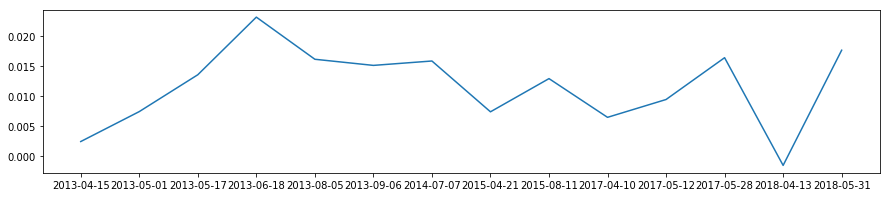

In [56]:
plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['EVI'])
plt.show()

### 9. Why will it be very hard to obtain a valid results? - an example

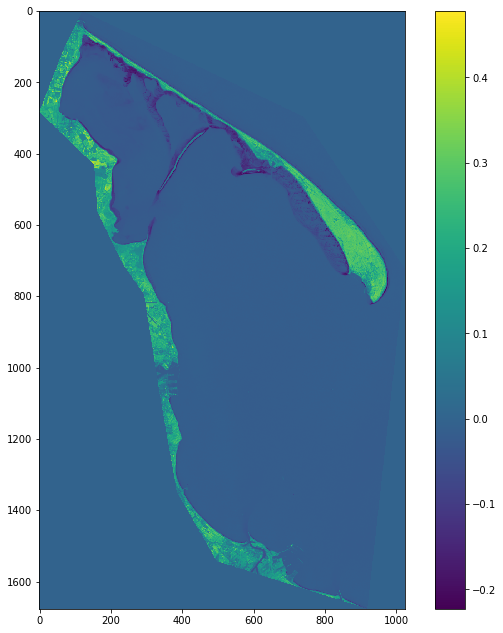

In [49]:
bands = [clean_df[clean_df.index == '2013-04-15'][0][0],
        clean_df[clean_df.index == '2013-04-15'][1][0],
        clean_df[clean_df.index == '2013-04-15'][2][0]]

before = calculate_evi(bands)
show_band(before, color_map='viridis', remove_negative=False)

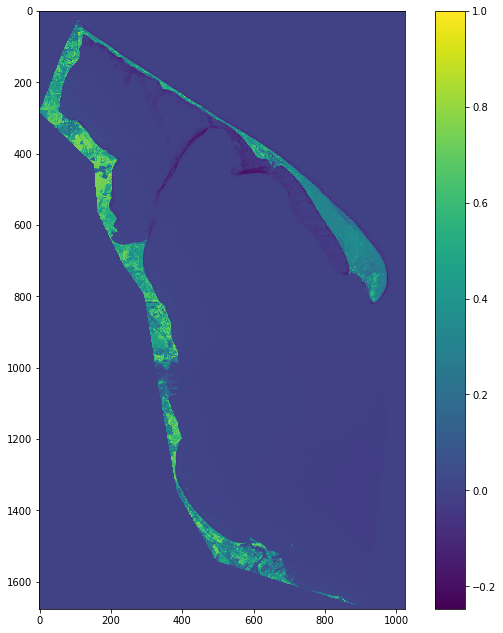

In [51]:
bands = [clean_df[clean_df.index == '2013-06-18'][0][0],
        clean_df[clean_df.index == '2013-06-18'][1][0],
        clean_df[clean_df.index == '2013-06-18'][2][0]]

after = calculate_evi(bands)
show_band(after, color_map='viridis', remove_negative=False)

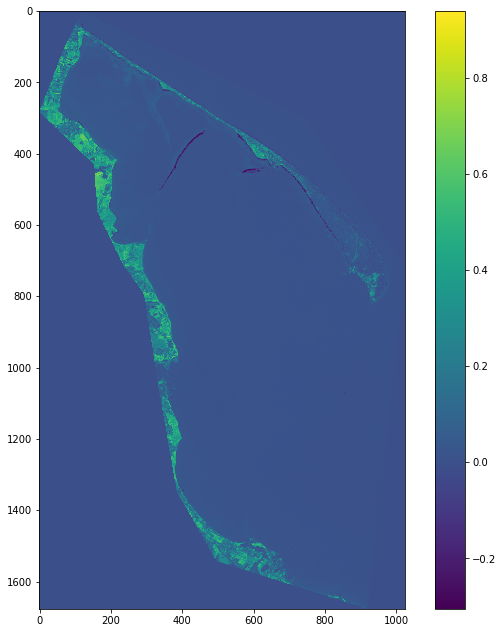

In [52]:
differences = after - before
show_band(differences, color_map='viridis', remove_negative=False)

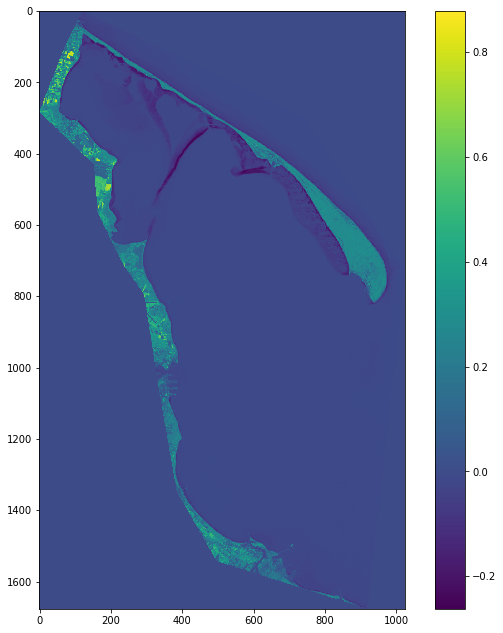

In [53]:
bands = [clean_df[clean_df.index == '2015-04-21'][0][0],
        clean_df[clean_df.index == '2015-04-21'][1][0],
        clean_df[clean_df.index == '2015-04-21'][2][0]]

before = calculate_evi(bands)
show_band(before, color_map='viridis', remove_negative=False)

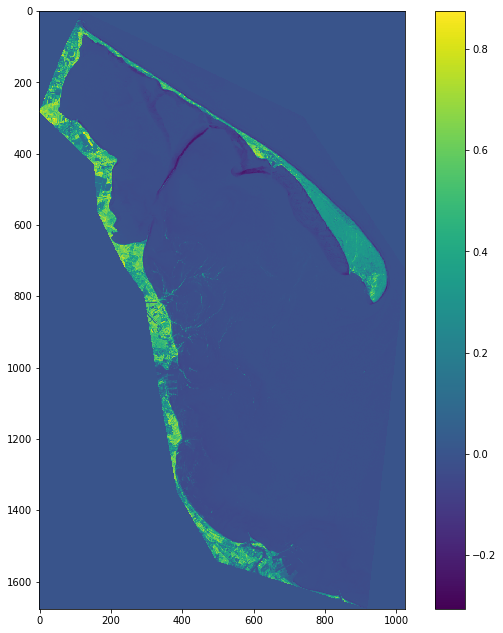

In [54]:
bands = [clean_df[clean_df.index == '2015-08-11'][0][0],
        clean_df[clean_df.index == '2015-08-11'][1][0],
        clean_df[clean_df.index == '2015-08-11'][2][0]]

after = calculate_evi(bands)
show_band(after, color_map='viridis', remove_negative=False)

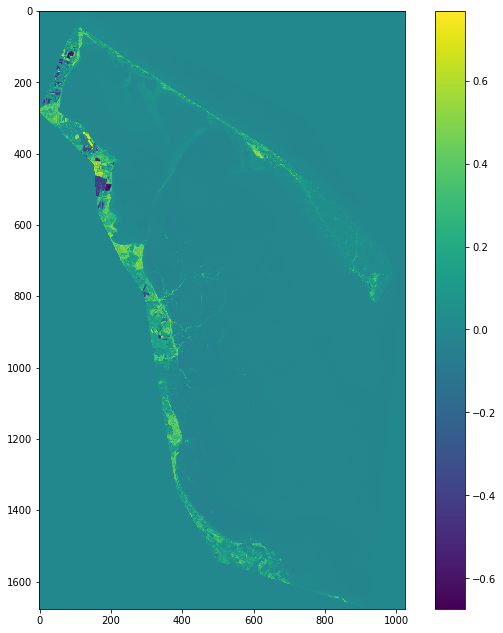

In [55]:
differences = after - before
show_band(differences, color_map='viridis', remove_negative=False)

### 10. Calculate EVI with corrected data.

--- Object geometry, properties, crs and schema updated ---
File: data/clipped/LC_band2_2013-04-15.tif saved successfully
File: data/clipped/LC_band4_2013-04-15.tif saved successfully
File: data/clipped/LC_band5_2013-04-15.tif saved successfully
File: data/clipped/LC_band2_2013-05-01.tif saved successfully
File: data/clipped/LC_band4_2013-05-01.tif saved successfully
File: data/clipped/LC_band5_2013-05-01.tif saved successfully
File: data/clipped/LC_band2_2013-05-17.tif saved successfully
File: data/clipped/LC_band4_2013-05-17.tif saved successfully
File: data/clipped/LC_band5_2013-05-17.tif saved successfully
File: data/clipped/LC_band2_2013-06-18.tif saved successfully
File: data/clipped/LC_band4_2013-06-18.tif saved successfully
File: data/clipped/LC_band5_2013-06-18.tif saved successfully
File: data/clipped/LC_band2_2013-08-05.tif saved successfully
File: data/clipped/LC_band4_2013-08-05.tif saved successfully
File: data/clipped/LC_band5_2013-08-05.tif saved successfully
File: data

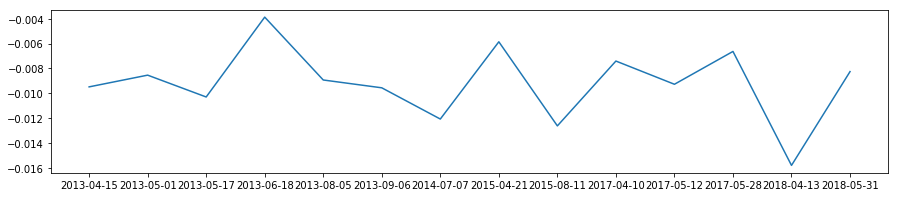

In [60]:
# Read and prepare vector data
vector_file = 'data/vector/zatoka_v2.shp'
vector_data = VectorData(vector_file)
vector_data.get_vector_data('geometry', True)

# Get projection from raster file
df = algal_blooms.landsat_dataframe
landsat_images = read_landsat_images(df['DIR'][0])
epsg = get_epsg_from_raster(landsat_images[1])

# Reproject vector geometry
vn = vector_data.reproject_geometry(epsg, False)

# Prepare area of interest
my_bands = (2, 4, 5)  # bands for EVI calculation
my_folder_name = 'data/clipped/'
prepared_files = clip_all(df, vn, my_bands, my_folder_name)

# Prepare dataframe and calculate EVI
clean_df = rasters_to_dataframe(prepared_files, df)
clean_df['EVI'] = clean_df.apply(lambda x: np.nanmean(calculate_evi([x[0], x[1], x[2]])), axis=1)

# Show EVI over time
plt.figure(figsize=(15, 3))
plt.plot(clean_df.index, clean_df['EVI'])
plt.show()

### 11. Clouds and remote sensing.

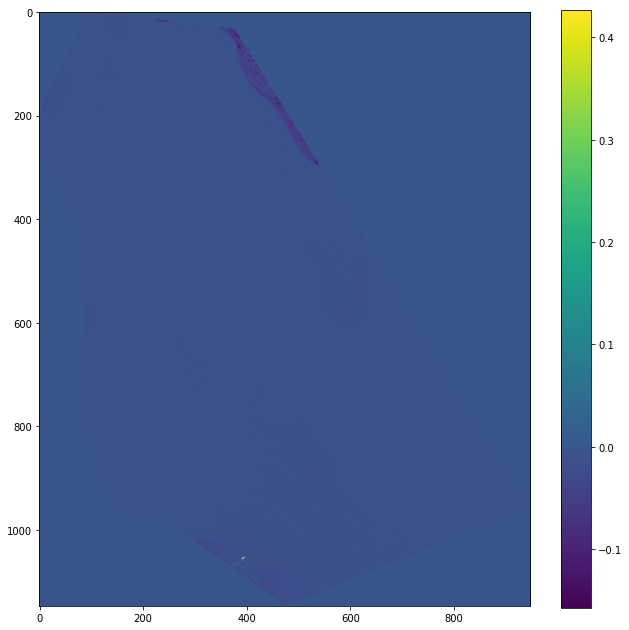

In [61]:
bands = [clean_df[clean_df.index == '2015-04-21'][0][0],
        clean_df[clean_df.index == '2015-04-21'][1][0],
        clean_df[clean_df.index == '2015-04-21'][2][0]]

before = calculate_evi(bands)
show_band(before, color_map='viridis', remove_negative=False)

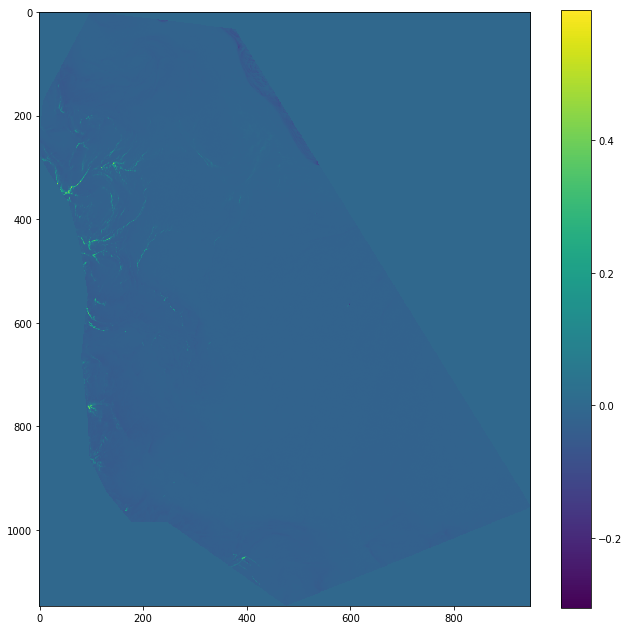

In [62]:
bands = [clean_df[clean_df.index == '2015-08-11'][0][0],
        clean_df[clean_df.index == '2015-08-11'][1][0],
        clean_df[clean_df.index == '2015-08-11'][2][0]]

after = calculate_evi(bands)
show_band(after, color_map='viridis', remove_negative=False)

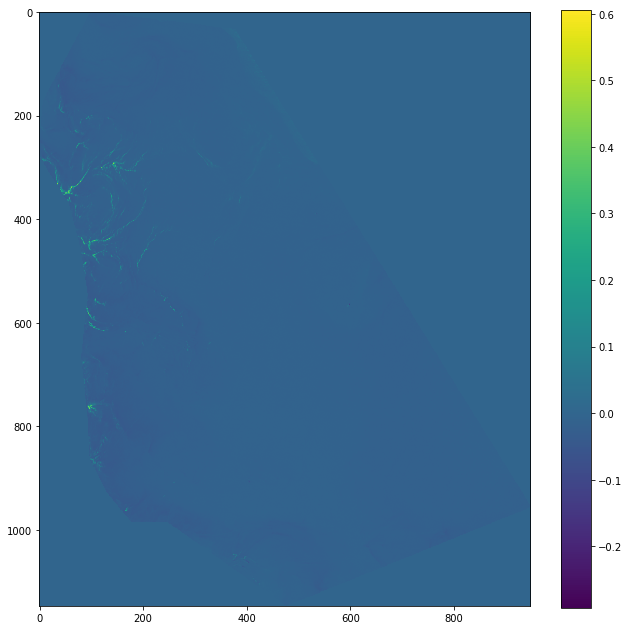

In [67]:
differences = after - before
show_band(differences, color_map='viridis', remove_negative=False)

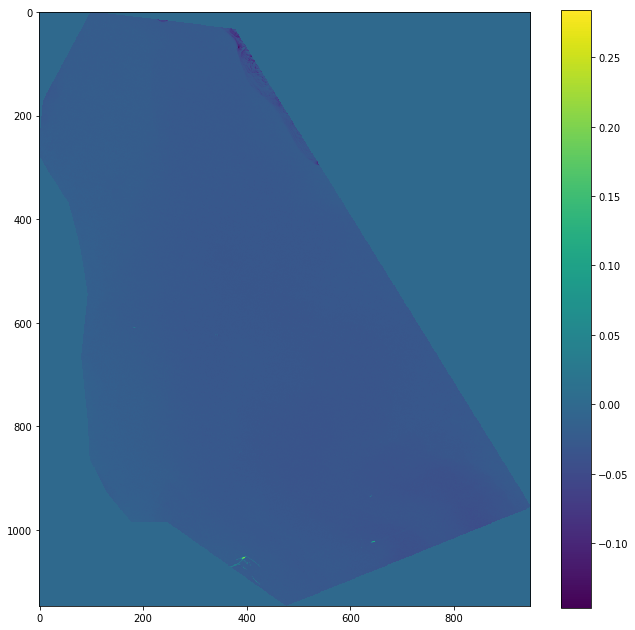

In [70]:
bands = [clean_df[clean_df.index == '2018-04-13'][0][0],
        clean_df[clean_df.index == '2018-04-13'][1][0],
        clean_df[clean_df.index == '2018-04-13'][2][0]]

test_band = calculate_evi(bands)
show_band(test_band, color_map='viridis', remove_negative=False)